# COGS 108 - EDA Checkpoint

# Names

* Arnav Tayal
* Chaewon Heo
* Martha Chow
* Zhiyi Zhu

<a id='research_question'></a>
# Research Question

Main question: Are characteristics of an individual’s diet (such as the amount of calories, macronutrients, and/or micronutrients) correlated with their likelihood of contracting COVID-19?

Sub-questions: Can we correlate diet type (eg. vegetarian, keto, pescetarian) with an individual’s likelihood of contracting COVID-19? Which characteristic is the strongest predictor?

Potential extension: Does correlation between a characteristic necessarily mean causation (eg. If we find that there is a positive correlation between kcal/day and likelihood of contracting COVID-19, does that necessarily mean that a high calorie diet leads to higher vulnerability to COVID-19?)? How much literature is there on databases to support the causal relationship?

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# packages for importing files
import os
import glob

__Get the add the Confirmed,Deaths,Recovered,Active,Population to the dataframe; those are directly extracted from the dataframe that records the precentages. Due to the time dependence of active COVID cases, it will be excluded from analysis. Beside the population, the unit for the other 3 quantitative columns are in percentages.__

In [2]:
df_covid = pd.read_csv('Food_Supply_Quantity_kg_Data.csv',usecols=['Country','Confirmed','Deaths','Recovered','Population'])
df_covid.head(6)

,Country,confirmed,deaths,recovered,population
0,Afghanistan,0.142134,0.006186,0.123374,38928000.0
1,Albania,2.967301,0.050951,1.792636,2838000.0
2,Algeria,0.244897,0.006558,0.167572,44357000.0
3,Angola,0.061687,0.001461,0.056808,32522000.0
4,Antigua and Barbuda,0.293878,0.007143,0.190816,98000.0
5,Argentina,4.356147,0.108227,3.905192,45377000.0


# Data Cleaning

__Process data for food quantity (unit: kg/capita/yr)__

In [3]:
# read in most csvs as a list
path = 'Food_Supply_Quantity_Kg'
all_files = glob.glob(os.path.join(path, "*.csv"))

In [4]:
# function that standardize food name; all lowercase + no space + no special character
def getName(n):
    name = n.replace(' ','_')
    name = name.replace('-','')
    name = name.replace(',','')
    name = name.replace('&','')
    name = name.replace('__','_')
    return name.lower()

In [5]:
# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_quantity = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_quantity.loc[0].at["Item"])
df_quantity = df_quantity.drop('Item', 1)
df_quantity.columns = ['country',name]

# merge all csvs in the directory into df_quantity
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_quantity = pd.merge(df_quantity,tmp,on ='country', how='outer')

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\1764355593.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_quantity = df_quantity.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\1764355593.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\1764355593.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\1764355593.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\

In [6]:
# we also need the Animal Product and Vegetal Product csvs that are in different forms, so add them to dataframe seperately
animal = pd.read_csv('FAOSTAT_food_kg_animal.csv')
animal.columns = ['country','animal_products'] 
vegetal_prod = pd.read_csv('FAOSTAT_food_kg_vegetal_prod.csv')
vegetal_prod.columns = ['country','vegetal_products']
df_quantity = pd.merge(df_quantity,animal,on ='country', how='outer')
df_quantity = pd.merge(df_quantity,vegetal_prod,on ='country', how='outer')

In [7]:
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_quantity = df_quantity.sort_index(axis=1)
first_column = df_quantity.pop('country')
df_quantity.insert(0, 'country', first_column)

# fill na with 0
df_quantity = df_quantity.fillna(0)

In [8]:
df_quantity.head(6)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,pulses,spices,starchy_roots,stimulants,sugar_crops,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products
0,Afghanistan,0.01,1.41,67.42,0.0,177.30,1.50,0.25,38.23,8.59,...,2.11,0.41,6.29,2.20,0.0,9.64,0.55,3.82,48.34,289.89
1,Albania,42.15,3.42,473.16,0.0,145.76,14.66,5.36,171.08,47.51,...,6.00,0.02,45.62,2.66,0.0,38.74,3.82,8.22,296.86,787.33
2,Algeria,4.33,0.45,153.89,0.0,218.56,8.43,3.86,101.92,18.06,...,7.64,0.89,66.04,3.54,0.0,29.30,1.84,16.47,186.08,644.82
3,Angola,66.33,0.64,56.27,0.0,104.01,0.67,20.22,68.52,23.49,...,7.43,0.01,206.80,0.58,0.0,21.12,0.07,7.38,26.31,514.68
4,Antigua and Barbuda,45.29,0.11,210.99,0.0,75.93,2.88,52.54,136.07,72.04,...,2.33,1.93,18.39,1.98,0.0,49.07,0.32,10.26,69.01,421.99
5,Argentina,66.28,3.47,300.48,0.0,130.63,15.50,7.29,93.87,109.38,...,0.82,0.19,47.25,6.80,0.0,47.43,0.31,14.82,67.57,476.16


In [9]:
df_quantity.shape

(173, 24)

__Process data for fat ( original unit: g/capita/day; will be converted to kg/capita/year)__

In [10]:
# function that converts g/capita/day to kg/capita/yr 
# TODO: someone check if this is correct
def standUnit(x):
    # g -> kg: / 1000
    # day -> year: * 365
    return x / 1000 * 365

In [11]:
# read in most csvs as a list
path = 'Fat_Supply'
all_files = glob.glob(os.path.join(path, "*.csv"))

# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_fat = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_fat.loc[0].at["Item"])
df_fat = df_fat.drop('Item', 1)
df_fat.columns = ['country',name]

# merge all csvs in the directory into df_fat
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_fat = pd.merge(df_fat,tmp,on ='country', how='outer')
    
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_fat = df_fat.sort_index(axis=1)
first_column = df_fat.pop('country')
df_fat.insert(0, 'country', first_column)

# replace na with 0
df_fat = df_fat.fillna(0)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3306572841.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_fat = df_fat.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3306572841.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3306572841.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3306572841.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Doc

In [12]:
# convert g/capita/day to kg/capita/yr
df_fat[df_fat.columns[1:len(df_fat.columns)]] = df_fat[df_fat.columns[1:len(df_fat.columns)]].applymap(standUnit)
df_fat

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,pulses,spices,starchy_roots,stimulants,sugar_crops,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products
0,Afghanistan,0.00000,1.39065,4.83625,0.0,1.79580,0.15330,0.0073,0.09490,1.36875,...,0.04380,0.06205,0.01095,0.02190,0.0000,0.0,0.16790,3.81790,0.08030,6.34005
1,Albania,0.00000,2.93460,27.48085,0.0,2.29585,1.41255,0.1241,0.55115,7.50805,...,0.09855,0.00000,0.04380,0.45260,0.0000,0.0,0.78840,7.93875,0.55845,15.45775
2,Algeria,0.00000,0.52195,8.38770,0.0,2.44550,0.70810,0.1168,0.33580,2.26665,...,0.15695,0.09125,0.06570,0.16790,0.0000,0.0,0.50005,15.91765,0.29930,20.70280
3,Angola,0.00000,0.46720,5.44580,0.0,2.33235,0.05475,0.5037,0.12410,3.92375,...,0.11680,0.00365,0.25185,0.04015,0.0000,0.0,0.01095,7.99350,0.04380,12.34795
4,Antigua and Barbuda,0.00000,3.03680,18.02005,0.0,2.09145,0.25185,0.9928,0.79205,9.31480,...,0.04380,0.23360,0.02920,0.68620,0.0000,0.0,0.13140,9.39510,0.16060,14.50510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Venezuela (Bolivarian Republic of),0.00000,1.07310,7.72705,0.0,1.20450,0.31025,0.2701,0.45625,3.35800,...,0.05475,0.00000,0.06205,0.04015,0.0000,0.0,0.00730,13.97220,0.08760,15.94320
169,Viet Nam,0.00000,2.19000,19.04205,0.0,2.12795,0.44895,0.6424,0.23360,15.13655,...,0.04380,0.36135,0.04015,0.04745,0.0219,0.0,0.67160,3.21930,0.36500,9.59585
170,Yemen,0.00000,0.57305,3.56970,0.0,3.28135,0.15695,0.1095,0.07300,2.27760,...,0.14235,0.02920,0.01460,0.10585,0.0000,0.0,0.02190,6.72695,0.04745,10.66165
171,Zambia,0.02555,0.52560,3.13170,0.0,4.67200,0.20440,0.3285,0.04380,1.59870,...,0.02555,0.05110,0.06570,0.02190,0.0000,0.0,0.00365,4.98590,0.05110,13.17650


__Process protein as fat__

In [13]:
# read in most csvs as a list
path = 'Protein_Supply'
all_files = glob.glob(os.path.join(path, "*.csv"))

# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_protein = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_protein.loc[0].at["Item"])
df_protein = df_protein.drop('Item', 1)
df_protein.columns = ['country',name]

# merge all csvs in the directory into df_protein
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_protein = pd.merge(df_protein,tmp,on ='country', how='outer')
    
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_protein = df_protein.sort_index(axis=1)
first_column = df_protein.pop('country')
df_protein.insert(0, 'country', first_column)

# replace na with 0
df_protein = df_protein.fillna(0)
df_protein.head(3)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3721737032.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_protein = df_protein.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3721737032.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3721737032.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3721737032.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tmp = tmp.drop('Item', 1)
C:\Users\Pu

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,pulses,spices,starchy_roots,stimulants,sugar_crops,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products
0,Afghanistan,0.00,0.03,10.55,0.0,38.92,0.44,0.07,0.63,3.39,...,1.35,0.18,0.21,0.60,0.0,0.00,0.15,0.00,1.23,43.54
1,Albania,0.44,0.17,66.34,0.0,34.03,4.32,1.50,3.05,18.31,...,3.48,0.00,2.12,0.63,0.0,0.01,0.64,0.02,7.76,53.21
2,Algeria,0.06,0.01,25.71,0.0,49.36,2.40,1.18,2.16,6.52,...,4.74,0.33,2.72,0.86,0.0,0.00,0.51,0.05,5.81,67.21


In [14]:
# convert g/capita/day to kg/capita/yr
df_protein[df_protein.columns[1:len(df_protein.columns)]] = df_protein[df_protein.columns[1:len(df_protein.columns)]].applymap(standUnit)
df_protein.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,pulses,spices,starchy_roots,stimulants,sugar_crops,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products
0,Afghanistan,0.0000,0.01095,3.85075,0.0,14.20580,0.1606,0.02555,0.22995,1.23735,...,0.49275,0.06570,0.07665,0.21900,0.0,0.00000,0.05475,0.00000,0.44895,15.89210
1,Albania,0.1606,0.06205,24.21410,0.0,12.42095,1.5768,0.54750,1.11325,6.68315,...,1.27020,0.00000,0.77380,0.22995,0.0,0.00365,0.23360,0.00730,2.83240,19.42165
2,Algeria,0.0219,0.00365,9.38415,0.0,18.01640,0.8760,0.43070,0.78840,2.37980,...,1.73010,0.12045,0.99280,0.31390,0.0,0.00000,0.18615,0.01825,2.12065,24.53165


# Data Analysis & Results (EDA)

In [15]:
pip install patsy

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import patsy
# packages for importing files
import os
import glob

## Creating Summary Dataframe ##

In [17]:
col_names = df_fat.columns

In [18]:
country_names = list(df_fat['country'])
covid_names = ['confirmed', 'deaths', 'recovered', 'active',
       'population']
macronutrient_source_names = ['alcoholic_beverages', 'animal_fats',
       'animal_products', 'aquatic_products_other', 'cereals_excluding_beer',
       'eggs', 'fish_seafood', 'fruits_excluding_wine', 'meat',
       'milk_excluding_butter', 'miscellaneous', 'offals', 'oilcrops',
       'pulses', 'spices', 'starchy_roots', 'stimulants', 'sugar_crops',
       'sugar_sweeteners', 'treenuts', 'vegetable_oils', 'vegetables',
       'vegetal_products']

In [19]:
# yearly fat intake of first three countries (alphabetical) (unit: kg/capita/yr)
fat_sum = df_fat[macronutrient_source_names].sum(axis=1)
fat_sum.head(3)

0    22.34895
1    85.87720
2    58.17735
dtype: float64

In [20]:
# yearly protein intake of first three countries (alphabetical) (unit: kg/capita/yr)
protein_sum = df_protein[macronutrient_source_names].sum(axis=1)
protein_sum.head(3)

0    39.48570
1    87.26785
2    67.82430
dtype: float64

In [21]:
#yearly carbohydrate intake of first three countries (alphabetical) (unit: kg/capita/yr)
#computed by total quantity-protein-fat
carb_sum=df_quantity.sum(axis=1)-protein_sum-fat_sum
carb_sum.head(3)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16092\3701914948.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  carb_sum=df_quantity.sum(axis=1)-protein_sum-fat_sum


0     652.80535
1    2347.89495
2    1471.46835
dtype: float64

In [22]:
# create macronutrients summary dataframe
df_macro = pd.DataFrame({'country': country_names,
                          'fat_sum': fat_sum,
                          'protein_sum': protein_sum,
                          'carb_sum':carb_sum})

In [23]:
df_macro

,country,fat_sum,protein_sum,carb_sum
0,Afghanistan,22.34895,39.48570,652.80535
1,Albania,85.87720,87.26785,2347.89495
2,Algeria,58.17735,67.82430,1471.46835
3,Angola,35.58385,39.49300,1066.82315
4,Antigua and Barbuda,65.04665,59.45120,1141.85215
...,...,...,...,...
168,Venezuela (Bolivarian Republic of),47.32955,74.97465,945.83580
169,Viet Nam,57.27215,74.12055,1295.53730
170,Yemen,28.46635,65.95185,510.52180
171,Zambia,32.62005,76.37625,603.00370


In [24]:
fat_max, protein_max, carb_max = max(df_macro['fat_sum']), max(df_macro['protein_sum']),  max(df_macro['carb_sum'])
print('Maximum Fat Value: ' + str(fat_max), '\nMaximum Protein Value: ' + str(protein_max),'\nMaximum Carbohydrate Value: ' + str(carb_max),)

fat_min, protein_min, carb_min = min(df_macro['fat_sum']), min(df_macro['protein_sum']),  min(df_macro['carb_sum'])
print('Minimum Fat Value: ' + str(fat_min), '\nMinimum Protein Value: ' + str(protein_min),'\nMinimum Carbohydrate Value: ' + str(carb_min),)

Maximum Fat Value: 122.05964999999998 
Maximum Protein Value: 102.93365 
Maximum Carbohydrate Value: 2347.89495
Minimum Fat Value: 17.1477 
Minimum Protein Value: 29.127000000000002 
Minimum Carbohydrate Value: 510.5218


## Histogram of Worldwide Macronutrient Distribution ##
* `x` : percentage ranges
* `y` : count of countries that fall under the percentage range

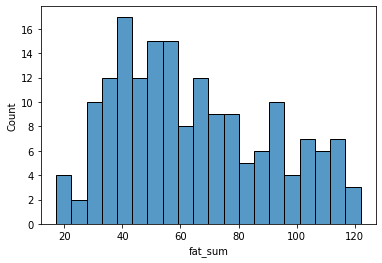

In [25]:
# fat intake distribution worldwide
fig1 = sns.histplot(x='fat_sum', data=df_macro, stat='count', bins=20)

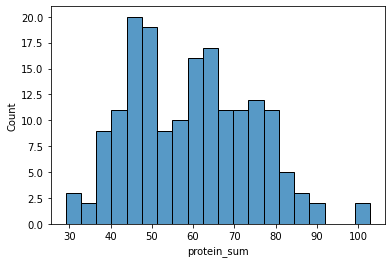

In [26]:
# protein intake distribution worldwide
fig2 = sns.histplot(x='protein_sum', data=df_macro, stat='count', bins=20)

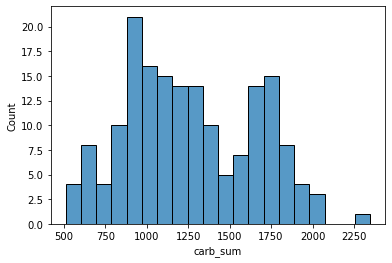

In [27]:
# carb intake distribution worldwide
fig3 = sns.histplot(x='carb_sum', data=df_macro, stat='count', bins=20)

## Histogram of Worldwide Covid Distribution ##
* `x` : percentage of each case
* `y` : count of countries that fall under each bin

In [37]:
print('Total number of countries in the dataset: '+ str(len(df_covid['Country'])))

Total number of countries in the dataset: 170


In [38]:
# covid confirmed cases distribution worldwide
fig3 = sns.histplot(x='confirmed', data=df_covid, stat='count', bins=20)

ValueError: Could not interpret value `confirmed` for parameter `x`

In [ ]:
# covid deaths cases distribution worldwide
fig4 = sns.histplot(x='deaths', data=df_covid, stat='count', bins=20)

In [ ]:
# covid recovered cases distribution worldwide
fig3 = sns.histplot(x='recovered', data=df_covid, stat='count', bins=20)

## Is there a correlation between macronutrient consumption and COVID rates in a country? ##

In [35]:
# combine macronutrient dataframe with COVID dataframe
macro_covid_combined_df = pd.concat([df_macro, df_covid], axis=1)
macro_covid_combined_df.head()

,country,fat_sum,protein_sum,carb_sum,Country,Confirmed,Deaths,Recovered,Population
0,Afghanistan,22.34895,39.48570,652.80535,Afghanistan,0.142134,0.006186,0.123374,38928000.0
1,Albania,85.87720,87.26785,2347.89495,Albania,2.967301,0.050951,1.792636,2838000.0
2,Algeria,58.17735,67.82430,1471.46835,Algeria,0.244897,0.006558,0.167572,44357000.0
3,Angola,35.58385,39.49300,1066.82315,Angola,0.061687,0.001461,0.056808,32522000.0
4,Antigua and Barbuda,65.04665,59.45120,1141.85215,Antigua and Barbuda,0.293878,0.007143,0.190816,98000.0


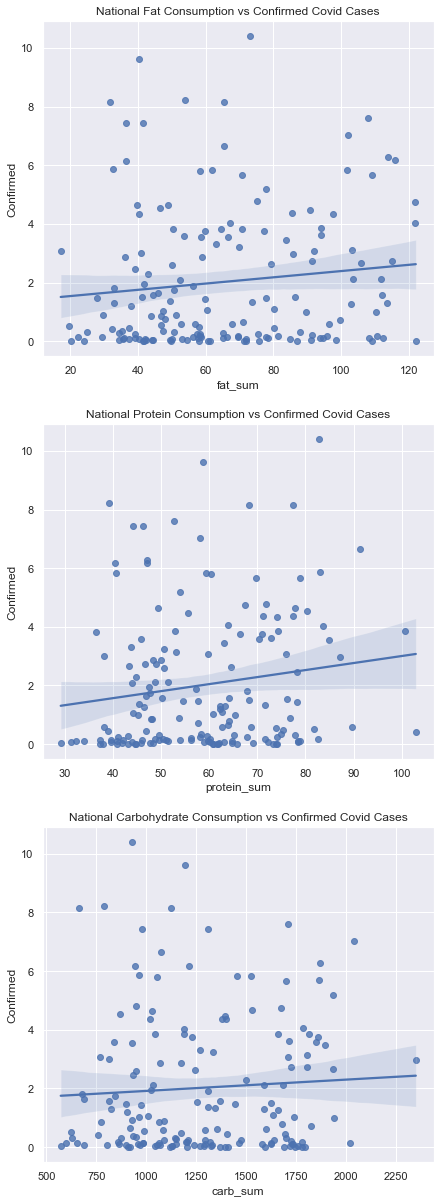

In [39]:
# generate scatterplots with a regression line to visualize relationship 
# between macronutrient consumption and confirmed COVID cases
sns.set()
fig, axes = plt.subplots(3,1)
sns.regplot(data = macro_covid_combined_df, x = 'fat_sum', y = 'Confirmed', ax = axes[0])
axes[0].set_title('National Fat Consumption vs Confirmed Covid Cases')
sns.regplot(data = macro_covid_combined_df, x = 'protein_sum', y = 'Confirmed', ax = axes[1])
axes[1].set_title('National Protein Consumption vs Confirmed Covid Cases')
sns.regplot(data = macro_covid_combined_df, x = 'carb_sum', y = 'Confirmed', ax = axes[2])
axes[2].set_title('National Carbohydrate Consumption vs Confirmed Covid Cases')

# set subplot size
fig.set_figheight(21)
fig.set_figwidth(7)

In [41]:
# Linear regression on fat consumption and covid cases
outcome_fat, predictors_fat = patsy.dmatrices('Confirmed ~ fat_sum', macro_covid_combined_df)
mod_fat = sm.OLS(outcome_fat, predictors_fat)
res_fat = mod_fat.fit()
print(res_fat.summary())

                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.304
Date:                Fri, 20 May 2022   Prob (F-statistic):              0.131
Time:                        18:44:04   Log-Likelihood:                -371.90
No. Observations:                 164   AIC:                             747.8
Df Residuals:                     162   BIC:                             754.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3274      0.493      2.692      0.0

In [42]:
# Linear regression on protein consumption and covid cases
outcome_protein, predictors_protein = patsy.dmatrices('Confirmed ~ protein_sum', macro_covid_combined_df)
mod_protein = sm.OLS(outcome_protein, predictors_protein)
res_protein = mod_protein.fit()
print(res_protein.summary())

                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.740
Date:                Fri, 20 May 2022   Prob (F-statistic):             0.0549
Time:                        18:44:27   Log-Likelihood:                -371.18
No. Observations:                 164   AIC:                             746.4
Df Residuals:                     162   BIC:                             752.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6111      0.752      0.812      

In [43]:
# Linear regression on carbohydrate consumption and covid cases
outcome_carb, predictors_carb = patsy.dmatrices('Confirmed ~ carb_sum', macro_covid_combined_df)
mod_carb = sm.OLS(outcome_carb, predictors_carb)
res_carb = mod_carb.fit()
print(res_carb.summary())

                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6132
Date:                Fri, 20 May 2022   Prob (F-statistic):              0.435
Time:                        18:44:43   Log-Likelihood:                -372.75
No. Observations:                 164   AIC:                             749.5
Df Residuals:                     162   BIC:                             755.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5288      0.656      2.329      0.0

__Interpretation__

In all three of the scatterplots, we can observe a subtle linear relationship between the two variables using the regression line. 

The results of the linear regression analysis suggest that there are not statistically signficant relationships between fat consumption and COVID cases, protein consumption and COVID cases, and carb consumption and COVID cases. We can see that the 95% confidence interval for all three coefficients include 0. 

__Outstanding issues__

1) We don't have carbohydrate supply data and are calculating carbohydrate intake by substracting total quantity by fat and protein quantity; this isn't very accurate

2) Some of the COVID data values greater than 1 (eg. Confirmed % for Argentina is 4.356147); this affects our histograms and linear regression analysis. Until we find a solution for this, we can't determine outliers.
